In [118]:
import pandas as pd, psycopg2
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
def query_database(connection, sql, *args, **kwargs):
    if connection.get_transaction_status() == 3:
        connection.reset()
    with connection.cursor() as cursor:
        cursor.execute(sql, *args, **kwargs)
        rows = cursor.fetchall()
        columns = [d[0] for d in cursor.description]
    df = pd.DataFrame(rows, columns=columns)
    return df

In [120]:
connection = psycopg2.connect('postgres://fga@localhost/fga')

In [121]:
sql = '''
with events_ as (
    select
        "createdAt" as ts,
        "currentUser" as user_id,
        "userDevice" as device_id
        
    from events
    
), devices_ as (
    select
        "Id" as device_id,
        "DeviceOS" as client,
        "UserID" as user_id,
        "CreatedAt" as created_at
        
    from devices
    
), device_count as (
    select
        user_id,
        device_id,
        client,
        created_at,
        row_number() over (partition by user_id order by created_at) as device_count
        
    from devices_
    
    order by 1

), users_ as (
    select
        user_id,
        device_id,
        client,
        created_at
        
    from device_count
    
    where device_count = 1

), cohort_sizes as (
    select
        created_at::date as date,
        client,
        count(distinct user_id) as cohort_size
        
    from users_
    
    group by 1, 2
    
    order by 1, 2
        
), d1_active_users as (
    select
        created_at::date as date,
        client,
        count(distinct events_.user_id) as d1_active_users
        
    from events_ join users_ using (user_id)
        
    where ts::date = created_at::date + 1
    
    group by 1, 2
    
), d1_retention as (
    select
        date,
        client,
        d1_active_users::float / cohort_size * 100 as d1_retention
        
    from d1_active_users l
        join cohort_sizes r using (date, client)
    
), d7_active_users as (
    select
        created_at::date as date,
        client,
        count(distinct events_.user_id) as d7_active_users
        
    from events_ join users_ using (user_id)
        
    where ts::date = created_at::date + 7
    
    group by 1, 2
    
), d7_retention as (
    select
        date,
        client,
        d7_active_users::float / cohort_size * 100 as d7_retention
        
    from d7_active_users
        join cohort_sizes using (date, client)
    
), d14_active_users as (
    select
        created_at::date as date,
        client,
        count(distinct events_.user_id) as d14_active_users
        
    from events_ join users_ using (user_id)
        
    where ts::date = created_at::date + 14
    
    group by 1, 2
    
), d14_retention as (
    select
        date,
        client,
        d14_active_users::float / cohort_size * 100 as d14_retention
        
    from d14_active_users 
        join cohort_sizes  
            using(date, client)
    
), d28_active_users as (
    select
        created_at::date as date,
        client,
        count(distinct events_.user_id) as d28_active_users
        
    from events_ join users_ using (user_id)
        
    where ts::date = created_at::date + 28
    
    group by 1, 2
    
), d28_retention as (
    select
        date,
        client,
        d28_active_users::float / cohort_size * 100 as d28_retention
        
    from d28_active_users
        join cohort_sizes
            using (date, client)
    
), results as (
    select
        date,
        client,
        d1_retention,
        d7_retention,
        d14_retention,
        d28_retention
        
    from d1_retention 
        left join d7_retention using (date, client)
        left join d14_retention using (date, client)
        left join d28_retention using (date, client)

)

select * from results
'''

df = query_database(connection, sql)
df.head()

,date,client,d1_retention,d7_retention,d14_retention,d28_retention
0,2019-10-13,Android,36.521739,25.217391,20.000000,6.086957
1,2019-10-13,iOS,35.238095,24.761905,10.476190,5.714286
2,2019-10-14,Android,53.846154,30.769231,12.820513,2.564103
3,2019-10-14,iOS,56.140351,22.807018,14.035088,5.263158
4,2019-10-15,iOS,68.750000,6.250000,NaN,NaN


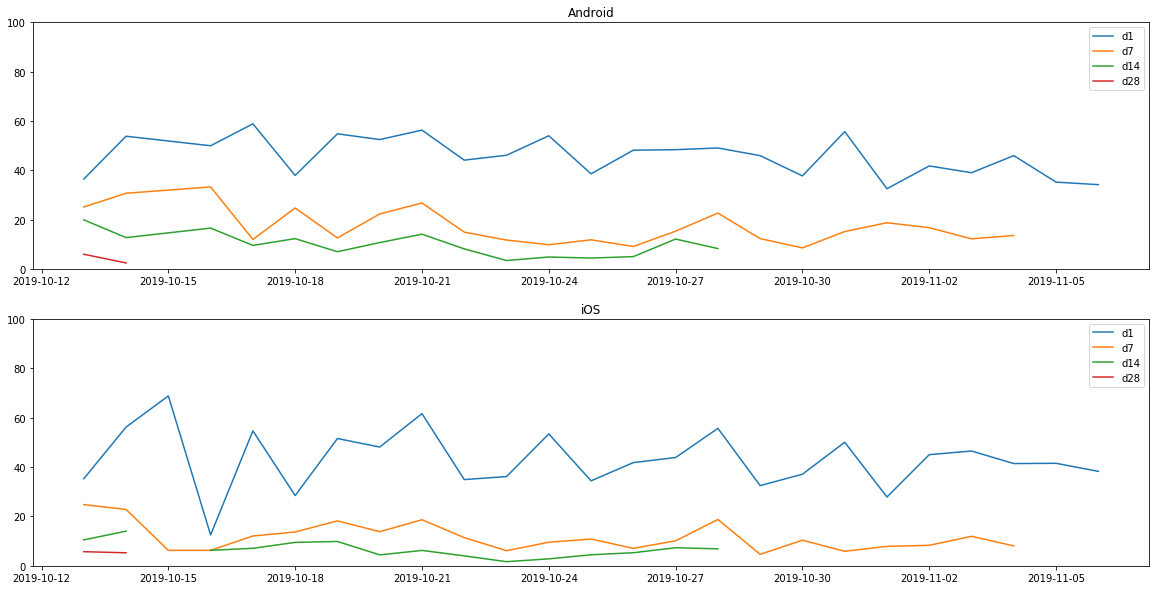

In [122]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
for i, (client, df_) in enumerate(df.groupby('client')):
    ax = axes[i]
    for d in [1, 7, 14, 28]:
        ax.plot(df_['date'], df_[f'd{d}_retention'], label=f'd{d}')
    ax.legend()
    ax.set_title(client)
    ax.set_ylim(0, 100)